## Imports

## Imports

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Agregar path para importar ml_utils
sys.path.append(str(Path('.').resolve()))
from ml_utils import evaluate_model, plot_feature_importance, compare_models

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Cargar Datos

In [4]:
DATA_PATH = Path("../.data/processed/")

train_df = pd.read_pickle(DATA_PATH / "train.pkl")

print(f"Train dataset: {train_df.shape}")
print(f"\nColumnas disponibles:")
for i, col in enumerate(train_df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nDistribución del target:")
print(train_df['target'].value_counts().sort_index())
print(f"\nProporción de disasters: {train_df['target'].mean():.2%}")

Train dataset: (7613, 14)

Columnas disponibles:
 1. id
 2. keyword
 3. location
 4. text
 5. target
 6. text_length
 7. word_count
 8. hashtag_count
 9. mention_count
10. url_count
11. uppercase_percentage
12. punctuation_percentage
13. keyword_clean
14. text_lemmatized

Distribución del target:
target
0    4342
1    3271
Name: count, dtype: int64

Proporción de disasters: 42.97%


## Preparar Features

Usaremos:
- **7 features numéricas**: text_length, word_count, hashtag_count, mention_count, url_count, uppercase_percentage, punctuation_percentage
- **TF-IDF**: 100 features del texto lematizado (incluye bigrams)
- **OneHot**: ~100 categorías de keywords

In [5]:
# Features numéricas
numeric_features = [
    'text_length',
    'word_count',
    'hashtag_count',
    'mention_count',
    'url_count',
    'uppercase_percentage',
    'punctuation_percentage'
]

print(f"Features numéricas: {len(numeric_features)}")

# Preparar datasets
X_numeric = train_df[numeric_features]
X_text = train_df['text_lemmatized'].fillna('')
X_keyword = train_df[['keyword_clean']].fillna('unknown')
y = train_df['target']

print(f"\nShapes:")
print(f"  X_numeric: {X_numeric.shape}")
print(f"  X_text: {X_text.shape}")
print(f"  X_keyword: {X_keyword.shape}")
print(f"  y: {y.shape}")

Features numéricas: 7

Shapes:
  X_numeric: (7613, 7)
  X_text: (7613,)
  X_keyword: (7613, 1)
  y: (7613,)


## Split Train/Validation

80/20 split estratificado.

In [6]:
# Split
X_numeric_train, X_numeric_val, \
X_text_train, X_text_val, \
X_keyword_train, X_keyword_val, \
y_train, y_val = train_test_split(
    X_numeric, X_text, X_keyword, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {len(y_train)} samples")
print(f"Val set: {len(y_val)} samples")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en val: {y_val.value_counts().to_dict()}")

Train set: 6090 samples
Val set: 1523 samples

Distribución en train: {0: 3473, 1: 2617}
Distribución en val: {0: 869, 1: 654}


## Feature Engineering Pipeline

1. StandardScaler para features numéricas
2. TfidfVectorizer para texto (max 100 features, bigrams)
3. OneHotEncoder para keywords (max 100 categorías)
4. Combinar todo

In [7]:
# 1. Escalar numéricas
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_val_scaled = scaler.transform(X_numeric_val)

# 2. TF-IDF para texto (incluye bigrams)
tfidf = TfidfVectorizer(
    max_features=100,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)  # unigrams y bigrams
)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

# 3. OneHotEncoder para keywords
onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='infrequent_if_exist',
    max_categories=100
)
X_keyword_train_encoded = onehot_encoder.fit_transform(X_keyword_train)
X_keyword_val_encoded = onehot_encoder.transform(X_keyword_val)

print("Features transformadas:")
print(f"  Numéricas escaladas: {X_numeric_train_scaled.shape}")
print(f"  TF-IDF (texto + bigrams): {X_text_train_tfidf.shape}")
print(f"  OneHot (keywords): {X_keyword_train_encoded.shape}")

# 4. Combinar
X_train_combined = np.hstack([
    X_numeric_train_scaled,
    X_text_train_tfidf,
    X_keyword_train_encoded
])

X_val_combined = np.hstack([
    X_numeric_val_scaled,
    X_text_val_tfidf,
    X_keyword_val_encoded
])

print("\n✅ Features combinadas:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Validation: {X_val_combined.shape}")

Features transformadas:
  Numéricas escaladas: (6090, 7)
  TF-IDF (texto + bigrams): (6090, 100)
  OneHot (keywords): (6090, 100)

✅ Features combinadas:
  Train: (6090, 207)
  Validation: (1523, 207)


## GridSearchCV - Búsqueda de Hiperparámetros

Buscaremos los mejores hiperparámetros para Random Forest.
Usaremos F1 Score como métrica de evaluación.

In [8]:
# Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Modelo base
rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

# F1 scorer
f1_scorer = make_scorer(f1_score)

# GridSearchCV con 5-fold cross-validation
print("Iniciando GridSearchCV...")
print(f"Combinaciones a probar: {np.prod([len(v) for v in param_grid.values()])}")
print("⚠️ Esto puede tomar 10-30 minutos...\n")

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit
grid_search.fit(X_train_combined, y_train)

print("\n✅ GridSearchCV completado")

Iniciando GridSearchCV...
Combinaciones a probar: 432
⚠️ Esto puede tomar 10-30 minutos...

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total

## Resultados de GridSearchCV

In [9]:
print("=" * 70)
print("RESULTADOS DE GRIDSEARCHCV".center(70))
print("=" * 70)

print(f"\n🏆 Mejor F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\n📋 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Top 5 configuraciones
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\n🔝 Top 5 Configuraciones:")
for idx, row in top_5.iterrows():
    print(f"\n  F1 Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

print("=" * 70)

                      RESULTADOS DE GRIDSEARCHCV                      

🏆 Mejor F1 Score (CV): 0.6959

📋 Mejores hiperparámetros:
  class_weight: balanced_subsample
  max_depth: None
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 200

🔝 Top 5 Configuraciones:

  F1 Score: 0.6959 (±0.0129)
  Params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

  F1 Score: 0.6956 (±0.0098)
  Params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

  F1 Score: 0.6950 (±0.0105)
  Params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

  F1 Score: 0.6948 (±0.0135)
  Params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 

## Evaluación en Validación

     EVALUACIÓN: Random Forest (Best from GridSearchCV)     

📊 Métricas:
  F1 Score:  0.7100  ⭐ (métrica principal)
  Accuracy:  0.7630
  Precision: 0.7479
  Recall:    0.6758


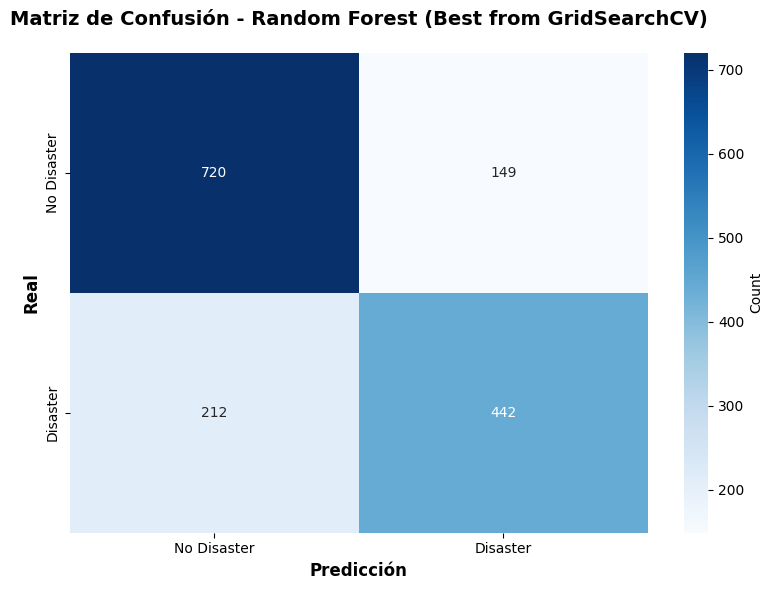


📋 Classification Report:
              precision    recall  f1-score   support

 No Disaster       0.77      0.83      0.80       869
    Disaster       0.75      0.68      0.71       654

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [10]:
# Mejor modelo
best_rf = grid_search.best_estimator_

# Predecir
y_pred_val = best_rf.predict(X_val_combined)

# Evaluar
results_rf = evaluate_model(y_val, y_pred_val, "Random Forest (Best from GridSearchCV)")

## Feature Importance

In [11]:
# Construir nombres de features
feature_names = []

# Numéricas
feature_names.extend(numeric_features)

# TF-IDF
tfidf_names = [f"text_{word}" for word in tfidf.get_feature_names_out()]
feature_names.extend(tfidf_names)

# Keywords
keyword_names = [f"keyword_{cat.replace('keyword_clean_', '')}" 
                 for cat in onehot_encoder.get_feature_names_out()]
feature_names.extend(keyword_names)

print(f"Total feature names: {len(feature_names)}")
print(f"Total features en modelo: {len(best_rf.feature_importances_)}")

# Verificar
assert len(feature_names) == len(best_rf.feature_importances_), \
    "Mismatch entre feature names y feature importances"

Total feature names: 207
Total features en modelo: 207


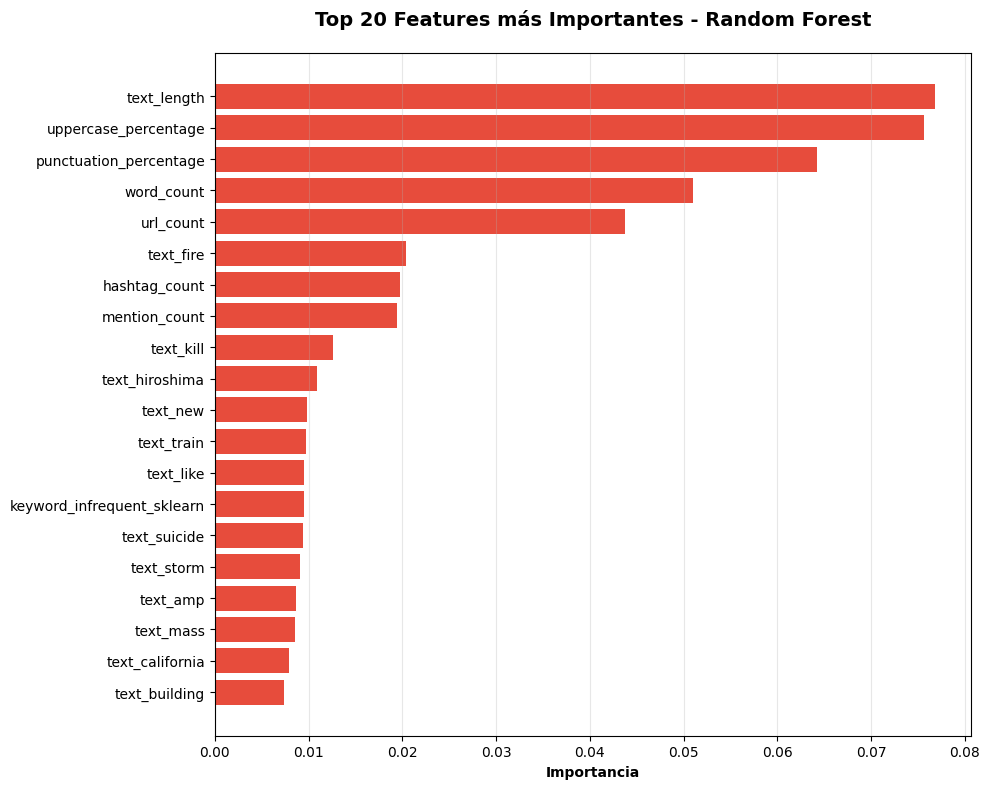


🔝 Top 10 Features Más Importantes:
                   feature  importance
0              text_length    0.076842
5     uppercase_percentage    0.075609
6   punctuation_percentage    0.064279
1               word_count    0.050959
4                url_count    0.043790
45               text_fire    0.020414
2            hashtag_count    0.019773
3            mention_count    0.019413
56               text_kill    0.012607
52          text_hiroshima    0.010854


In [12]:
# Graficar importancia
importance_df = plot_feature_importance(
    feature_names,
    best_rf.feature_importances_,
    "Random Forest",
    top_n=20
)

# Mostrar top 10
print("\n🔝 Top 10 Features Más Importantes:")
print(importance_df.head(10).to_string())

## Análisis de Overfitting

In [13]:
# Predecir en train
y_pred_train = best_rf.predict(X_train_combined)

# Evaluar (sin imprimir)
results_train = evaluate_model(y_train, y_pred_train, print_results=False)
results_val = evaluate_model(y_val, y_pred_val, print_results=False)

# Comparar
comparison = pd.DataFrame({
    'Train': results_train,
    'Validation': results_val,
    'Diferencia': {k: results_train[k] - results_val[k] for k in results_train.keys()}
})

print("=" * 60)
print("COMPARACIÓN TRAIN vs VALIDATION".center(60))
print("=" * 60)
print(comparison.T.to_string())
print("=" * 60)

# Análisis
diff_f1 = results_train['f1'] - results_val['f1']
if diff_f1 > 0.05:
    print(f"\n⚠️ Posible overfitting detectado (diferencia F1: {diff_f1:.4f})")
elif diff_f1 < 0:
    print(f"\n⚠️ Performance mejor en validación que train (diferencia F1: {diff_f1:.4f})")
else:
    print(f"\n✅ Buen balance entre train y validation (diferencia F1: {diff_f1:.4f})")

              COMPARACIÓN TRAIN vs VALIDATION               
                  f1  accuracy  precision    recall
Train       0.951994  0.959278   0.964692  0.939626
Validation  0.710040  0.762968   0.747885  0.675841
Diferencia  0.241954  0.196310   0.216807  0.263785

⚠️ Posible overfitting detectado (diferencia F1: 0.2420)


## Resumen del Modelo

In [14]:
print("=" * 70)
print("RESUMEN: RANDOM FOREST CON GRIDSEARCHCV".center(70))
print("=" * 70)

print(f"\n📊 Performance:")
print(f"  F1 Score (CV):         {grid_search.best_score_:.4f}")
print(f"  F1 Score (Train):      {results_train['f1']:.4f}")
print(f"  F1 Score (Validation): {results_val['f1']:.4f}  ⭐")

print(f"\n🎯 Target: F1 > 0.80")
if results_val['f1'] > 0.80:
    print(f"  ✅ OBJETIVO CUMPLIDO (F1 = {results_val['f1']:.4f})")
else:
    print(f"  ❌ Por debajo del objetivo (F1 = {results_val['f1']:.4f})")
    print(f"     Falta: {0.80 - results_val['f1']:.4f}")

print(f"\n🔧 Configuración:")
print(f"  Algoritmo: Random Forest")
print(f"  Features totales: {X_train_combined.shape[1]}")
print(f"  Búsqueda: GridSearchCV (5-fold CV)")
print(f"  Combinaciones probadas: {len(results_df)}")

print(f"\n🏆 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n" + "=" * 70)

               RESUMEN: RANDOM FOREST CON GRIDSEARCHCV                

📊 Performance:
  F1 Score (CV):         0.6959
  F1 Score (Train):      0.9520
  F1 Score (Validation): 0.7100  ⭐

🎯 Target: F1 > 0.80
  ❌ Por debajo del objetivo (F1 = 0.7100)
     Falta: 0.0900

🔧 Configuración:
  Algoritmo: Random Forest
  Features totales: 207
  Búsqueda: GridSearchCV (5-fold CV)
  Combinaciones probadas: 432

🏆 Mejores hiperparámetros:
  class_weight: balanced_subsample
  max_depth: None
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 200



## Predicciones para Competencia

In [15]:
# Cargar test
test_df = pd.read_pickle(DATA_PATH / "test.pkl")

print(f"Test dataset: {test_df.shape}")

# Preparar features
X_test_numeric = test_df[numeric_features]
X_test_text = test_df['text_lemmatized'].fillna('')
X_test_keyword = test_df[['keyword_clean']].fillna('unknown')

# Transformar
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_test_text_tfidf = tfidf.transform(X_test_text).toarray()
X_test_keyword_encoded = onehot_encoder.transform(X_test_keyword)

# Combinar
X_test_combined = np.hstack([
    X_test_numeric_scaled,
    X_test_text_tfidf,
    X_test_keyword_encoded
])

print(f"Test features combinadas: {X_test_combined.shape}")

# Predecir
test_predictions = best_rf.predict(X_test_combined)

print(f"\nPredicciones generadas: {len(test_predictions)}")
print(f"Distribución de predicciones:")
print(pd.Series(test_predictions).value_counts().sort_index())

Test dataset: (3263, 13)
Test features combinadas: (3263, 207)

Predicciones generadas: 3263
Distribución de predicciones:
0    2053
1    1210
Name: count, dtype: int64

Predicciones generadas: 3263
Distribución de predicciones:
0    2053
1    1210
Name: count, dtype: int64


In [16]:
# Crear submission
test_raw = pd.read_csv(Path("../.data/raw/") / "test.csv")
submission = pd.DataFrame({
    'id': test_raw['id'],
    'target': test_predictions
})

# Guardar
OUTPUT_PATH = Path("../.data/submissions/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

submission_file = OUTPUT_PATH / "model1_random_forest.csv"
submission.to_csv(submission_file, index=False)

print(f"✅ Submission guardado en: {submission_file}")
print(f"\nPrimeras 5 filas:")
print(submission.head())
print(f"\nÚltimas 5 filas:")
print(submission.tail())

✅ Submission guardado en: ../.data/submissions/model1_random_forest.csv

Primeras 5 filas:
   id  target
0   0       0
1   2       1
2   3       1
3   9       1
4  11       0

Últimas 5 filas:
         id  target
3258  10861       0
3259  10865       1
3260  10868       0
3261  10874       1
3262  10875       1


In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Agregar path para importar ml_utils
sys.path.append(str(Path('.').resolve()))
from ml_utils import evaluate_model, plot_feature_importance, compare_models, COLOR_NO_DISASTER, COLOR_DISASTER, COLOR_GENERAL

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Cargar Datos

In [18]:
DATA_PATH = Path("../.data/processed/")

# Cargar datos básicos
train_df = pd.read_pickle(DATA_PATH / "train.pkl")

print(f"Train dataset: {train_df.shape}")
print(f"\nColumnas disponibles:")
for i, col in enumerate(train_df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nDistribución del target:")
print(train_df['target'].value_counts().sort_index())
print(f"\nProporción de disasters: {train_df['target'].mean():.2%}")

Train dataset: (7613, 14)

Columnas disponibles:
 1. id
 2. keyword
 3. location
 4. text
 5. target
 6. text_length
 7. word_count
 8. hashtag_count
 9. mention_count
10. url_count
11. uppercase_percentage
12. punctuation_percentage
13. keyword_clean
14. text_lemmatized

Distribución del target:
target
0    4342
1    3271
Name: count, dtype: int64

Proporción de disasters: 42.97%


## Preparar Features

Usaremos las features básicas disponibles:
- **Numéricas básicas**: 7 features de texto (length, word_count, etc.)
- **Texto**: TF-IDF del texto lematizado  
- **Keywords**: OneHotEncoder de keywords

In [19]:
# Features numéricas básicas
numeric_features = [
    'text_length',
    'word_count',
    'hashtag_count',
    'mention_count',
    'url_count',
    'uppercase_percentage',
    'punctuation_percentage'
]

print(f"Features numéricas: {len(numeric_features)}")

# Preparar datasets
X_numeric = train_df[numeric_features]
X_text = train_df['text_lemmatized'].fillna('')
X_keyword = train_df[['keyword_clean']].fillna('unknown')
y = train_df['target']

print(f"\nShapes:")
print(f"  X_numeric: {X_numeric.shape}")
print(f"  X_text: {X_text.shape}")
print(f"  X_keyword: {X_keyword.shape}")
print(f"  y: {y.shape}")

Features numéricas: 7

Shapes:
  X_numeric: (7613, 7)
  X_text: (7613,)
  X_keyword: (7613, 1)
  y: (7613,)


## Split Train/Validation

80/20 split estratificado para mantener proporción de clases.

In [20]:
# Split indices
X_numeric_train, X_numeric_val, \
X_location_train, X_location_val, \
X_text_train, X_text_val, \
X_keyword_train, X_keyword_val, \
y_train, y_val = train_test_split(
    X_numeric, X_location, X_text, X_keyword, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {len(y_train)} samples")
print(f"Val set: {len(y_val)} samples")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en val: {y_val.value_counts().to_dict()}")

NameError: name 'X_location' is not defined

## Feature Engineering Pipeline

1. StandardScaler para features numéricas
2. TfidfVectorizer para texto (max 100 features)
3. OneHotEncoder para keywords (max 100 categorías)
4. Combinar todo en una matriz

In [ ]:
# 1. Escalar numéricas
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_val_scaled = scaler.transform(X_numeric_val)

# 2. Location ya está preparada (fillna con -999)
X_location_train_scaled = scaler.fit_transform(X_location_train)
X_location_val_scaled = scaler.transform(X_location_val)

# 3. TF-IDF para texto
tfidf = TfidfVectorizer(
    max_features=100,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)  # unigrams y bigrams
)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

# 4. OneHotEncoder para keywords
onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='infrequent_if_exist',
    max_categories=100
)
X_keyword_train_encoded = onehot_encoder.fit_transform(X_keyword_train)
X_keyword_val_encoded = onehot_encoder.transform(X_keyword_val)

print("Features transformadas:")
print(f"  Numéricas escaladas: {X_numeric_train_scaled.shape}")
print(f"  Location escaladas: {X_location_train_scaled.shape}")
print(f"  TF-IDF (texto + bigrams): {X_text_train_tfidf.shape}")
print(f"  OneHot (keywords): {X_keyword_train_encoded.shape}")

# 5. Combinar todas las features
X_train_combined = np.hstack([
    X_numeric_train_scaled,
    X_location_train_scaled,
    X_text_train_tfidf,
    X_keyword_train_encoded
])

X_val_combined = np.hstack([
    X_numeric_val_scaled,
    X_location_val_scaled,
    X_text_val_tfidf,
    X_keyword_val_encoded
])

print("\n✅ Features combinadas:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Validation: {X_val_combined.shape}")

## GridSearchCV - Búsqueda de Hiperparámetros

Buscaremos los mejores hiperparámetros para Random Forest:
- **n_estimators**: número de árboles
- **max_depth**: profundidad máxima
- **min_samples_split**: mínimo de samples para split
- **min_samples_leaf**: mínimo de samples en hoja
- **max_features**: número de features por split

Usaremos F1 Score como métrica de evaluación.

In [ ]:
# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Crear modelo base
rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

# F1 scorer
f1_scorer = make_scorer(f1_score)

# GridSearchCV con 5-fold cross-validation
print("Iniciando GridSearchCV...")
print(f"Combinaciones a probar: {np.prod([len(v) for v in param_grid.values()])}")
print("Esto puede tomar varios minutos...\n")

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit
grid_search.fit(X_train_combined, y_train)

print("\n✅ GridSearchCV completado")

## Resultados de GridSearchCV

In [ ]:
print("=" * 70)
print("RESULTADOS DE GRIDSEARCHCV".center(70))
print("=" * 70)

print(f"\n🏆 Mejor F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\n📋 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Top 5 configuraciones
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\n🔝 Top 5 Configuraciones:")
for idx, row in top_5.iterrows():
    print(f"\n  F1 Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

print("=" * 70)

## Entrenar Modelo Final con Mejores Hiperparámetros

In [ ]:
# Obtener mejor modelo
best_rf = grid_search.best_estimator_

print(f"Modelo final: {best_rf}")
print(f"\nNúmero de features utilizadas: {X_train_combined.shape[1]}")

## Evaluación en Validación

In [ ]:
# Predecir
y_pred_val = best_rf.predict(X_val_combined)

# Evaluar usando ml_utils
results_rf = evaluate_model(y_val, y_pred_val, "Random Forest (Best from GridSearchCV)")

## Feature Importance

Random Forest proporciona importancia de features basada en Gini impurity.

In [ ]:
# Construir nombres de features
feature_names = []

# Numéricas
feature_names.extend(numeric_features)

# Location
feature_names.extend(['location_lat', 'location_lon'])

# TF-IDF
tfidf_names = [f"text_{word}" for word in tfidf.get_feature_names_out()]
feature_names.extend(tfidf_names)

# Keywords
keyword_names = [f"keyword_{cat.replace('keyword_clean_', '')}" 
                 for cat in onehot_encoder.get_feature_names_out()]
feature_names.extend(keyword_names)

print(f"Total feature names: {len(feature_names)}")
print(f"Total features en modelo: {len(best_rf.feature_importances_)}")

# Verificar que coinciden
assert len(feature_names) == len(best_rf.feature_importances_), \
    "Mismatch entre feature names y feature importances"

In [ ]:
# Usar función de ml_utils para graficar
importance_df = plot_feature_importance(
    feature_names,
    best_rf.feature_importances_,
    "Random Forest",
    top_n=20
)

# Mostrar top 10
print("\n🔝 Top 10 Features Más Importantes:")
print(importance_df.head(10).to_string())

## Análisis de Overfitting

Comparar performance en train vs validation:

In [ ]:
# Predecir en train
y_pred_train = best_rf.predict(X_train_combined)

# Evaluar (sin imprimir)
results_train = evaluate_model(y_train, y_pred_train, print_results=False)
results_val = evaluate_model(y_val, y_pred_val, print_results=False)

# Comparar
comparison = pd.DataFrame({
    'Train': results_train,
    'Validation': results_val,
    'Diferencia': {k: results_train[k] - results_val[k] for k in results_train.keys()}
})

print("=" * 60)
print("COMPARACIÓN TRAIN vs VALIDATION".center(60))
print("=" * 60)
print(comparison.T.to_string())
print("=" * 60)

# Análisis
diff_f1 = results_train['f1'] - results_val['f1']
if diff_f1 > 0.05:
    print(f"\n⚠️ Posible overfitting detectado (diferencia F1: {diff_f1:.4f})")
elif diff_f1 < 0:
    print(f"\n⚠️ Performance mejor en validación que train (diferencia F1: {diff_f1:.4f})")
    print("   Esto puede indicar que el validation set es más fácil.")
else:
    print(f"\n✅ Buen balance entre train y validation (diferencia F1: {diff_f1:.4f})")

## Resumen del Modelo

In [ ]:
print("=" * 70)
print("RESUMEN: RANDOM FOREST CON GRIDSEARCHCV".center(70))
print("=" * 70)

print(f"\n📊 Performance:")
print(f"  F1 Score (CV):         {grid_search.best_score_:.4f}")
print(f"  F1 Score (Train):      {results_train['f1']:.4f}")
print(f"  F1 Score (Validation): {results_val['f1']:.4f}  ⭐")

print(f"\n🎯 Target: F1 > 0.80")
if results_val['f1'] > 0.80:
    print(f"  ✅ OBJETIVO CUMPLIDO (F1 = {results_val['f1']:.4f})")
else:
    print(f"  ❌ Por debajo del objetivo (F1 = {results_val['f1']:.4f})")
    print(f"     Falta: {0.80 - results_val['f1']:.4f}")

print(f"\n🔧 Configuración:")
print(f"  Algoritmo: Random Forest")
print(f"  Features totales: {X_train_combined.shape[1]}")
print(f"  Búsqueda: GridSearchCV (5-fold CV)")
print(f"  Combinaciones probadas: {len(results_df)}")

print(f"\n🏆 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n" + "=" * 70)

## Predicciones para Competencia

Generamos predicciones en el test set para Kaggle.

In [ ]:
# Cargar test
test_df = pd.read_pickle(DATA_PATH / "test_advanced.pkl")

print(f"Test dataset: {test_df.shape}")

# Preparar features igual que train
X_test_numeric = test_df[numeric_features]
X_test_location = test_df[location_features].fillna(-999)
X_test_text = test_df['text_lemmatized'].fillna('')
X_test_keyword = test_df[['keyword_clean']].fillna('unknown')

# Transformar
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_test_location_scaled = scaler.transform(X_test_location)
X_test_text_tfidf = tfidf.transform(X_test_text).toarray()
X_test_keyword_encoded = onehot_encoder.transform(X_test_keyword)

# Combinar
X_test_combined = np.hstack([
    X_test_numeric_scaled,
    X_test_location_scaled,
    X_test_text_tfidf,
    X_test_keyword_encoded
])

print(f"Test features combinadas: {X_test_combined.shape}")

# Predecir
test_predictions = best_rf.predict(X_test_combined)

print(f"\nPredicciones generadas: {len(test_predictions)}")
print(f"Distribución de predicciones:")
print(pd.Series(test_predictions).value_counts().sort_index())

In [ ]:
# Crear submission
test_raw = pd.read_csv(Path("../.data/raw/") / "test.csv")
submission = pd.DataFrame({
    'id': test_raw['id'],
    'target': test_predictions
})

# Guardar
OUTPUT_PATH = Path("../.data/submissions/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

submission_file = OUTPUT_PATH / "model1_random_forest.csv"
submission.to_csv(submission_file, index=False)

print(f"✅ Submission guardado en: {submission_file}")
print(f"\nPrimeras 5 filas:")
print(submission.head())
print(f"\nÚltimas 5 filas:")
print(submission.tail())